# Theme Park Optimization - Canada's Wonderland

## Problem Statement
Optimize a theme park visit to minimize total time spent while maximizing preference value of visited attractions, considering:
- Time-dependent wait times throughout the day
- Walking distances between attractions
- Individual ride durations
- Visitor preferences for different attractions

This is an extension of the Traveling Salesman Problem with additional complexity.

In [35]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

# Set up visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Simplified Model Setup

### Decision Variables
- $x_i$ : Binary variable indicating whether attraction $i$ is visited (1) or skipped (0)
- $y_{ij}$ : Binary variable indicating travel from attraction $i$ to attraction $j$
- $t_i$ : Continuous variable for the time when we arrive at attraction $i$

### Objective Function
Maximize: $\sum_{i} (\text{preference}_i \cdot x_i) - \alpha \cdot \text{total\_time}$

Where:
- $\alpha$ is a weighting factor balancing preference vs. time
- total_time includes wait times, ride durations, and walking times

In [36]:
# Load attraction data from CSV
df_attractions = pd.read_csv('data/attractions.csv')
df_attractions = df_attractions.set_index('id')
print("Attractions:")
print(df_attractions)
print(f"\nTotal attractions: {len(df_attractions)}")

Attractions:
                         name  preference  ride_duration
id                                                      
1                   Leviathan          10            3.5
2                    Behemoth           9            3.0
3               Yukon Striker          10            3.8
4   Great Canadian Minebuster           6            5.0
5                     The Bat           7            2.0
6                      Vortex           8            3.0

Total attractions: 6


In [37]:
# Load distance matrix from CSV (n x n format)
df_distances_raw = pd.read_csv('data/distances.csv', index_col=0)

# Validation: Check if matrix is square
n_rows, n_cols = df_distances_raw.shape
if n_rows != n_cols:
    raise ValueError(f"Distance matrix is not square: expected N×N, got {n_rows}×{n_cols}")

# Validation: Check if size matches (n_attractions + 1 for entrance)
expected_size = len(df_attractions) + 1
if n_rows != expected_size:
    raise ValueError(
        f"Distance matrix size mismatch: expected {expected_size}×{expected_size} "
        f"({len(df_attractions)} attractions + entrance), got {n_rows}×{n_rows}"
    )

# Validation: Check if matrix is symmetric
distance_matrix = df_distances_raw.values
if not np.allclose(distance_matrix, distance_matrix.T):
    # Find first asymmetric entry for helpful error message
    for i in range(n_rows):
        for j in range(i+1, n_cols):
            if not np.isclose(distance_matrix[i, j], distance_matrix[j, i]):
                raise ValueError(
                    f"Distance matrix is not symmetric: "
                    f"distance from ID {i} to ID {j} ({distance_matrix[i, j]}) != "
                    f"distance from ID {j} to ID {i} ({distance_matrix[j, i]})"
                )

print("✓ Distance matrix validation passed")
print(f"  - Matrix is square: {n_rows}×{n_cols}")
print(f"  - Matrix is symmetric")
print(f"  - Size matches: {len(df_attractions)} attractions + 1 entrance")

# Create mapping: ID -> Name (0 is Entrance, 1-N are attractions)
id_to_name = {0: 'Entrance'}
id_to_name.update(df_attractions['name'].to_dict())

# Create DataFrame with names as labels for readability
location_names = [id_to_name[int(id)] for id in df_distances_raw.index]
df_distances = pd.DataFrame(distance_matrix, 
                            columns=location_names,
                            index=location_names)

n_attractions = len(df_attractions)
print("\nWalking times (minutes):")
print(df_distances)

✓ Distance matrix validation passed
  - Matrix is square: 7×7
  - Matrix is symmetric
  - Size matches: 6 attractions + 1 entrance

Walking times (minutes):
                           Entrance  Leviathan  Behemoth  Yukon Striker  \
Entrance                          0          8        10             12   
Leviathan                         8          0         5              7   
Behemoth                         10          5         0              6   
Yukon Striker                    12          7         6              0   
Great Canadian Minebuster        15         10         8              5   
The Bat                          18         12        10              8   
Vortex                           10          5        13              8   

                           Great Canadian Minebuster  The Bat  Vortex  
Entrance                                          15       18      10  
Leviathan                                         10       12       5  
Behemoth                  

In [38]:
# Load wait time data from CSV
df_wait_times_raw = pd.read_csv('data/wait_times.csv')
df_wait_times_raw = df_wait_times_raw.set_index('id')

# Get hours from column names (converting to int)
hours = [int(col) for col in df_wait_times_raw.columns]

# Create a DataFrame with attraction names for display
df_wait_times = df_wait_times_raw.copy()
df_wait_times.index = df_wait_times.index.map(lambda id: df_attractions.loc[id, 'name'])

# Convert to dictionary format for easier access in functions
# Using attraction names as keys for compatibility with existing functions
wait_times = {}
for attraction_id in df_wait_times_raw.index:
    attraction_name = df_attractions.loc[attraction_id, 'name']
    wait_times[attraction_name] = df_wait_times_raw.loc[attraction_id].tolist()

print("\nWait times by hour (minutes):")
print(df_wait_times)


Wait times by hour (minutes):
                            9  10  11  12  13  14  15  16  17  18  19  20  21
id                                                                           
Leviathan                  15  25  35  45  50  55  60  50  40  30  20  15  10
Behemoth                   10  20  30  40  45  50  55  45  35  25  15  10   8
Yukon Striker              20  30  40  50  55  60  65  55  45  35  25  20  15
Great Canadian Minebuster   5  10  15  20  25  20  15  12  10   8   5   5   3
The Bat                     8  15  20  25  30  25  20  15  12  10   8   5   3
Vortex                      8  15  20  25  30  25  20  15  12  10   8   5   3


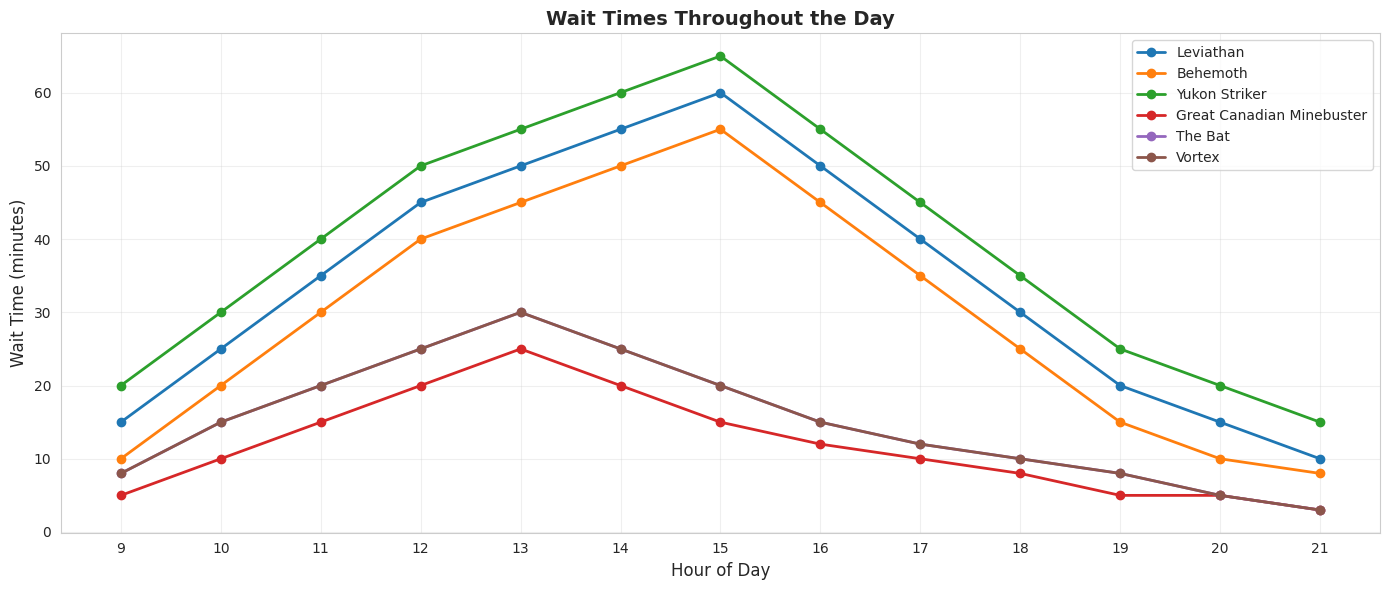

In [39]:
# Visualize wait times throughout the day
plt.figure(figsize=(14, 6))
for attraction in wait_times.keys():
    plt.plot(hours, wait_times[attraction], marker='o', label=attraction, linewidth=2)

plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Wait Time (minutes)', fontsize=12)
plt.title('Wait Times Throughout the Day', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(hours)
plt.tight_layout()
plt.show()

## 2. Problem Parameters

In [40]:
# Park parameters
PARK_OPEN = 9  # 9am
PARK_CLOSE = 21  # 9pm
AVAILABLE_HOURS = PARK_CLOSE - PARK_OPEN

# Optimization parameters
ALPHA = 0.1  # Weight for time penalty (tune this)
MIN_ATTRACTIONS = 3  # Minimum number of attractions to visit

print(f"Park operating hours: {PARK_OPEN}:00 to {PARK_CLOSE}:00")
print(f"Available time: {AVAILABLE_HOURS} hours ({AVAILABLE_HOURS * 60} minutes)")
print(f"Number of attractions: {n_attractions}")
print(f"Time penalty weight (alpha): {ALPHA}")

Park operating hours: 9:00 to 21:00
Available time: 12 hours (720 minutes)
Number of attractions: 6
Time penalty weight (alpha): 0.1


## 3. Helper Functions

In [41]:
def get_wait_time(attraction_name, hour):
    """
    Get wait time for an attraction at a specific hour.
    Uses linear interpolation for fractional hours.
    """
    hour_floor = int(np.floor(hour))
    hour_ceil = int(np.ceil(hour))
    
    # Boundary conditions
    if hour < PARK_OPEN:
        return wait_times[attraction_name][0]
    if hour >= PARK_CLOSE:
        return wait_times[attraction_name][-1]
    
    # Get indices
    idx_floor = hour_floor - PARK_OPEN
    idx_ceil = hour_ceil - PARK_OPEN
    
    if idx_ceil >= len(wait_times[attraction_name]):
        return wait_times[attraction_name][-1]
    
    # Linear interpolation
    frac = hour - hour_floor
    wait_floor = wait_times[attraction_name][idx_floor]
    wait_ceil = wait_times[attraction_name][idx_ceil]
    
    return wait_floor + frac * (wait_ceil - wait_floor)

# Test the function
print("Wait time for Leviathan at 10:30am:", get_wait_time('Leviathan', 10.5), "minutes")
print("Wait time for Behemoth at 2pm:", get_wait_time('Behemoth', 14), "minutes")

Wait time for Leviathan at 10:30am: 30.0 minutes
Wait time for Behemoth at 2pm: 50 minutes


In [42]:
def calculate_total_time(itinerary, start_hour=PARK_OPEN):
    """
    Calculate total time for a given itinerary.
    
    Args:
        itinerary: List of attraction names in visit order
        start_hour: Starting time (default: park opening)
    
    Returns:
        Dictionary with time breakdown and total preference score
    """
    current_time = start_hour
    current_location = 'Entrance'
    total_walk_time = 0
    total_wait_time = 0
    total_ride_time = 0
    total_preference = 0
    
    timeline = []
    
    for attraction in itinerary:
        # Walking time
        walk_time = df_distances.loc[current_location, attraction]
        current_time += walk_time / 60  # Convert to hours
        total_walk_time += walk_time
        
        # Wait time (depends on arrival time)
        wait_time = get_wait_time(attraction, current_time)
        current_time += wait_time / 60
        total_wait_time += wait_time
        
        # Ride time - look up by name in df_attractions
        ride_time = df_attractions[df_attractions['name'] == attraction]['ride_duration'].values[0]
        current_time += ride_time / 60
        total_ride_time += ride_time
        
        # Preference - look up by name in df_attractions
        preference = df_attractions[df_attractions['name'] == attraction]['preference'].values[0]
        total_preference += preference
        
        timeline.append({
            'attraction': attraction,
            'arrival_time': current_time - (wait_time + ride_time) / 60,
            'walk_time': walk_time,
            'wait_time': wait_time,
            'ride_time': ride_time
        })
        
        current_location = attraction
    
    # Walk back to entrance
    walk_back = df_distances.loc[current_location, 'Entrance']
    total_walk_time += walk_back
    current_time += walk_back / 60
    
    total_time = total_walk_time + total_wait_time + total_ride_time
    
    return {
        'timeline': timeline,
        'total_walk_time': total_walk_time,
        'total_wait_time': total_wait_time,
        'total_ride_time': total_ride_time,
        'total_time': total_time,
        'end_time': current_time,
        'total_preference': total_preference,
        'objective_value': total_preference - ALPHA * total_time
    }


In [43]:
# Test with a sample itinerary
sample_itinerary = ['Leviathan', 'Behemoth', 'Yukon Striker']
result = calculate_total_time(sample_itinerary)
print("\nSample itinerary:", sample_itinerary)
print(f"Total preference: {result['total_preference']}")
print(f"Total time: {result['total_time']:.1f} minutes")
print(f"  - Walking: {result['total_walk_time']:.1f} min")
print(f"  - Waiting: {result['total_wait_time']:.1f} min")
print(f"  - Riding: {result['total_ride_time']:.1f} min")
print(f"End time: {result['end_time']:.2f} ({int(result['end_time'])}:{int((result['end_time'] % 1) * 60):02d})")
print(f"Objective value: {result['objective_value']:.2f}")

sample_itinerary = ['Behemoth', 'Yukon Striker', 'The Bat', 'Great Canadian Minebuster', 'Vortex']
result = calculate_total_time(sample_itinerary)
print("\nSample itinerary:", sample_itinerary)
print(f"Total preference: {result['total_preference']}")
print(f"Total time: {result['total_time']:.1f} minutes")
print(f"  - Walking: {result['total_walk_time']:.1f} min")
print(f"  - Waiting: {result['total_wait_time']:.1f} min")
print(f"  - Riding: {result['total_ride_time']:.1f} min")
print(f"End time: {result['end_time']:.2f} ({int(result['end_time'])}:{int((result['end_time'] % 1) * 60):02d})")
print(f"Objective value: {result['objective_value']:.2f}")


Sample itinerary: ['Leviathan', 'Behemoth', 'Yukon Striker']
Total preference: 29
Total time: 102.7 minutes
  - Walking: 31.0 min
  - Waiting: 61.4 min
  - Riding: 10.3 min
End time: 10.71 (10:42)
Objective value: 18.73

Sample itinerary: ['Behemoth', 'Yukon Striker', 'The Bat', 'Great Canadian Minebuster', 'Vortex']
Total preference: 40
Total time: 153.9 minutes
  - Walking: 52.0 min
  - Waiting: 85.1 min
  - Riding: 16.8 min
End time: 11.56 (11:33)
Objective value: 24.61


## 4. Next Steps

The simplified model is now set up. To solve this optimization problem, we can:

1. **Greedy Heuristic**: Simple algorithm to test basic functionality
2. **Mixed Integer Linear Programming (MILP)**: Using PuLP or Gurobi
3. **Metaheuristics**: Genetic algorithms, simulated annealing, etc.

We'll need to choose an optimization library and formulate the constraints.

In [23]:
# Placeholder for optimization model
# TODO: Implement optimization using chosen method